In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta


import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv('burglaries_preprocessed.csv')
data = data[['Month', 'Ward']]

In [3]:
data

,Month,Ward
0,2010-12,High Barnet
1,2010-12,High Barnet
2,2010-12,High Barnet
3,2010-12,High Barnet
4,2010-12,High Barnet
...,...,...
44133,2023-03,Childs Hill
44134,2023-03,Childs Hill
44135,2023-03,Childs Hill
44136,2023-03,Childs Hill


In [4]:
def reg_evaluation(y_test, y_pred, ward: str):    
    print(f'Results for {ward}:')
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),2))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print('R2 score:', round(r2_score(y_test, y_pred),2))

In [5]:
def create_features(df):

    df = df.set_index('Month')
    df.index = pd.to_datetime(df.index)
#     df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['crime_count'] = 1
    
    return df

data = create_features(data)

# look below after adding features

In [6]:
def return_year_month(row):
    return str(row['year']) + '-' + str(row['month'])

In [7]:
data

,Ward,month,year,crime_count
Month,,,,
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
...,...,...,...,...
2023-03-01,Childs Hill,3,2023,1
2023-03-01,Childs Hill,3,2023,1
2023-03-01,Childs Hill,3,2023,1


In [8]:
data_aggr = data.groupby(['year', 'month', 'Ward']).count()
data_aggr.reset_index(inplace=True)


In [9]:
data_aggr.loc[450:500]

,year,month,Ward,crime_count
450,2012,6,Totteridge & Woodside,13
451,2012,6,Underhill,21
452,2012,6,West Finchley,23
453,2012,6,West Hendon,16
454,2012,6,Whetstone,19
455,2012,6,Woodhouse,27
456,2012,7,Barnet Vale,12
457,2012,7,Brunswick Park,10
458,2012,7,Burnt Oak,19
459,2012,7,Childs Hill,26


In [10]:
data_aggr['year_month'] = data_aggr.apply(return_year_month, axis=1)
data_aggr['date'] = data_aggr['year_month']
data_aggr = data_aggr.set_index('date')
data_aggr.index = pd.to_datetime(data_aggr.index)
data_aggr['timestamp']=data_aggr.index

In [11]:
data_aggr

,year,month,Ward,crime_count,year_month,timestamp
date,,,,,,
2010-12-01,2010,12,Barnet Vale,13,2010-12,2010-12-01
2010-12-01,2010,12,Brunswick Park,13,2010-12,2010-12-01
2010-12-01,2010,12,Burnt Oak,10,2010-12,2010-12-01
2010-12-01,2010,12,Childs Hill,20,2010-12,2010-12-01
2010-12-01,2010,12,Colindale North,7,2010-12,2010-12-01
...,...,...,...,...,...,...
2023-03-01,2023,3,Underhill,1,2023-3,2023-03-01
2023-03-01,2023,3,West Finchley,13,2023-3,2023-03-01
2023-03-01,2023,3,West Hendon,9,2023-3,2023-03-01


# IMPUTATION

In [12]:
wards_wo_month = []

for month in data_aggr['Ward'].unique():
    if data_aggr[data_aggr['Ward']==month].shape[0]<148:        
        wards_wo_month.append(month)

In [13]:
all_months = data_aggr.index.unique().to_list()
dct_impute = {}

for ward in wards_wo_month:
    
    lst_months=[]
    
    for i, row in data_aggr[data_aggr['Ward']==ward].iterrows():
        lst_months.append(i)
        dct_impute[ward] = list(set(all_months) - set(lst_months))[0]


In [14]:
dct_impute

{'Colindale North': Timestamp('2014-12-01 00:00:00'),
 'Colindale South': Timestamp('2016-10-01 00:00:00'),
 'Edgwarebury': Timestamp('2021-07-01 00:00:00'),
 'High Barnet': Timestamp('2022-12-01 00:00:00'),
 'Totteridge & Woodside': Timestamp('2021-05-01 00:00:00'),
 'Whetstone': Timestamp('2023-01-01 00:00:00'),
 'Woodhouse': Timestamp('2020-08-01 00:00:00')}

# fix cell after adding features


In [15]:
data_aggr = data_aggr.append(pd.DataFrame({'year':2014, 'month':12, 'Ward':'Colindale North', #'quarter':4, 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Colindale North']['crime_count'].mean()), 
                                           'year_month':'2014-12'}, index=[dct_impute['Colindale North']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2016, 'month':10, 'Ward':'Colindale South', #'quarter':4, 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Colindale South']['crime_count'].mean()), 
                                           'year_month':'2016-10'}, index=[dct_impute['Colindale South']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2021, 'month':7, 'Ward':'Edgwarebury', #'quarter':3, 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Edgwarebury']['crime_count'].mean()), 
                                           'year_month':'2021-7'}, index=[dct_impute['Edgwarebury']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2022, 'month':12, 'Ward':'High Barnet', #'quarter':4, 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='High Barnet']['crime_count'].mean()), 
                                           'year_month':'2014-12'}, index=[dct_impute['High Barnet']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2021, 'month':5, 'Ward':'Totteridge & Woodside', #'quarter':2, 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Totteridge & Woodside']['crime_count'].mean()), 
                                           'year_month':'2021-5'}, index=[dct_impute['Totteridge & Woodside']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2023, 'month':1, 'Ward':'Whetstone', #'quarter':1, 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Whetstone']['crime_count'].mean()), 
                                           'year_month':'2023-1'}, index=[dct_impute['Whetstone']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2020, 'month':8, 'Ward':'Woodhouse', #'quarter':3, 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Woodhouse']['crime_count'].mean()), 
                                           'year_month':'2020-8'}, index=[dct_impute['Woodhouse']]))

In [16]:
data_aggr.sort_index(inplace=True)

In [17]:
data_aggr

,year,month,Ward,crime_count,year_month,timestamp
2010-12-01,2010,12,Barnet Vale,13,2010-12,2010-12-01
2010-12-01,2010,12,Woodhouse,10,2010-12,2010-12-01
2010-12-01,2010,12,Whetstone,9,2010-12,2010-12-01
2010-12-01,2010,12,West Hendon,16,2010-12,2010-12-01
2010-12-01,2010,12,West Finchley,27,2010-12,2010-12-01
...,...,...,...,...,...,...
2023-03-01,2023,3,Childs Hill,20,2023-3,2023-03-01
2023-03-01,2023,3,Burnt Oak,13,2023-3,2023-03-01
2023-03-01,2023,3,Brunswick Park,13,2023-3,2023-03-01
2023-03-01,2023,3,Golders Green,14,2023-3,2023-03-01


# Model 1 - predicting crime rate for 1 ward

In [18]:
def data_split_1_ward(data, ward, end_train, end_val):
    
    FEATURES = ['month']
    TARGET = 'crime_count'
    
    WARD = ward
    data_1w = data[data['Ward']==WARD]
    
    train_1w = data.loc[data.index < end_train]
    val_1w = data.loc[(data.index >= end_train) & (data.index < end_val)]
    test_1w = data.loc[data.index >= end_val]
    
    X_train_1w = train_1w[FEATURES]
    y_train_1w = train_1w[TARGET]

    X_val_1w = val_1w[FEATURES]
    y_val_1w = val_1w[TARGET]

    X_test_1w = test_1w[FEATURES]
    y_test_1w = test_1w[TARGET]
    
    return X_train_1w, X_val_1w, X_test_1w, y_train_1w, y_val_1w, y_test_1w

In [19]:
X_train_childs_hill, X_val_childs_hill, X_test_childs_hill, y_train_childs_hill, y_val_childs_hill, y_test_childs_hill = data_split_1_ward(
    data_aggr, 'Childs Hill', '2022-01-01', '2022-08-01')



In [20]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=5000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=10,
                       learning_rate=0.0005)

reg.fit(X_train_childs_hill, y_train_childs_hill, eval_set=[(X_train_childs_hill, y_train_childs_hill), 
                                                            (X_val_childs_hill, y_val_childs_hill)], verbose=100)


[05:10:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14.09594	validation_1-rmse:9.44959
[100]	validation_0-rmse:13.56646	validation_1-rmse:8.94932
[200]	validation_0-rmse:13.06882	validation_1-rmse:8.48447
[300]	validation_0-rmse:12.60153	validation_1-rmse:8.05400
[400]	validation_0-rmse:12.16319	validation_1-rmse:7.65691
[500]	validation_0-rmse:11.75241	validation_1-rmse:7.29192
[600]	validation_0-rmse:11.36786	validation_1-rmse:6.95812
[700]	validation_0-rmse:11.00825	validation_1-rmse:6.65465
[800]	validation_0-rmse:10.67236	validation_1-rmse:6.38060
[900]	validation_0-rmse:10.35897	validation_1-rmse:6.13491
[1000]	validation_0-rmse:10.06693	validation_1-rmse:5.91638
[1100]	validation_0-rmse:9.79512	validation_1-rmse:5.72320
[1200]	validation_0-rmse:9.54244	validation_1-rmse:5.55497
[1300]	validation_0-rmse:9.30783	validation_1-rmse:5.4103

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0005, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [21]:
reg_evaluation(y_test_childs_hill, reg.predict(X_test_childs_hill), 'Childs hill')
# R2 is sus, very poor

Results for Childs hill:
Mean Absolute Error: 3.89
Root Mean Squared Error: 5.09
R2 score: 0.04


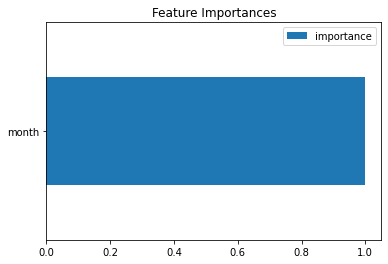

In [22]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importances')
plt.show()

# Model for all wards at once

In [45]:
def wmape(y_true, y_pred):
    '''Weighted Mean Absolute Percentage Error
    '''
    
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [46]:
train = data_aggr.loc[data_aggr.index < '2022-03-01']
#val = data_aggr.loc[(data_aggr.index >= '2022-01-01') & (data_aggr.index < '2022-08-01')]
val = data_aggr.loc[data_aggr.index >= '2022-03-01']

In [47]:
train.drop(columns=['year','timestamp'], inplace=True)

C:\Users\Goshko\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
train

,month,Ward,crime_count,year_month
2010-12-01,12,Barnet Vale,13,2010-12
2010-12-01,12,Woodhouse,10,2010-12
2010-12-01,12,Whetstone,9,2010-12
2010-12-01,12,West Hendon,16,2010-12
2010-12-01,12,West Finchley,27,2010-12
...,...,...,...,...
2022-02-01,2,Edgware,14,2022-2
2022-02-01,2,Edgwarebury,3,2022-2
2022-02-01,2,Finchley Church End,14,2022-2
2022-02-01,2,Friern Barnet,10,2022-2


In [49]:
from gluonts.dataset.pandas import PandasDataset

train_ds = PandasDataset.from_long_dataframe(train, target='crime_count', item_id='Ward', 
                                       timestamp='year_month', freq='M')

In [50]:
train_ds

PandasDataset(target='crime_count', feat_dynamic_real=None, past_feat_dynamic_real=None, timestamp=None, freq='M', future_length=0, unchecked=False, assume_sorted=False, dtype=<class 'numpy.float32'>, _data_entries=StarMap(fn=<bound method PandasDataset._pair_to_dataentry of ...>, iterable=Map(fn=<function pair_with_item_id at 0x0000020A433DA948>, iterable=[('Barnet Vale',             month         Ward  crime_count year_month
year_month                                            
2010-12-01     12  Barnet Vale           13    2010-12
2011-01-01      1  Barnet Vale           23     2011-1
2011-02-01      2  Barnet Vale           20     2011-2
2011-03-01      3  Barnet Vale           15     2011-3
2011-04-01      4  Barnet Vale           25     2011-4
...           ...          ...          ...        ...
2021-10-01     10  Barnet Vale            3    2021-10
2021-11-01     11  Barnet Vale            8    2021-11
2021-12-01     12  Barnet Vale            8    2021-12
2022-01-01      1  

In [59]:
from gluonts.torch.model.deepar import DeepAREstimator

estimator = DeepAREstimator(freq='M', prediction_length=6, num_layers=30, lr=0.001, context_length=12,
                            trainer_kwargs={'max_epochs':60})

predictor = estimator.train(train_ds, num_workers=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Goshko\anaconda3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,

  | Name  | Type        | Params | In sizes | Out sizes  
---------------------------------------------------------------
0 | model | DeepARModel | 390 K  | ?        | [1, 100, 6]
---------------------------------------------------------------
390 K     Trainable params
0         Non-trainable params
390 K     Total params
1.563     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 3.36988 (best 3.36988), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_12\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 3.00478 (best 3.00478), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_12\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 2.92969 (best 2.92969), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_12\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 2.91743 (best 2.91743), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_12\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 2.91024 (best 2.91024), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\vers

In [60]:
pred = list(predictor.predict(train_ds))

In [61]:
pred

[gluonts.model.forecast.SampleForecast(info=None, item_id='Barnet Vale', samples=array([[ 8.30032158e+00,  2.74726248e+00,  7.00256538e+00,
          3.44214725e+00,  4.95472050e+00,  6.94689322e+00],
        [ 8.14716244e+00,  4.95891094e+00,  5.48640823e+00,
          6.62783670e+00,  5.33763885e+00,  6.54389620e+00],
        [ 3.35556555e+00,  5.77882528e+00,  7.12507772e+00,
          4.79059076e+00,  1.15756578e+01,  7.76408005e+00],
        [ 5.91649103e+00,  6.40662670e+00,  1.13024845e+01,
          6.00792360e+00,  8.95156002e+00,  9.51706696e+00],
        [ 9.89746475e+00,  8.94320297e+00,  9.43618679e+00,
          3.09026450e-01, -3.77679974e-01,  4.38291645e+00],
        [ 6.09083319e+00,  5.96781015e+00,  6.76795578e+00,
          2.06433773e+00,  1.18593397e+01,  9.87351799e+00],
        [ 8.52935505e+00,  2.97368383e+00,  7.35493422e+00,
          1.18682635e+00,  2.91626525e+00,  6.41056871e+00],
        [ 1.02840443e+01,  3.22868085e+00,  3.15114784e+00,
          2.3

In [62]:
all_preds = list()
for ward in pred:
    ward_name = ward.item_id
    p = ward.samples.mean(axis=0)
    p10 = np.percentile(ward.samples, 10, axis=0)
    p90 = np.percentile(ward.samples, 90, axis=0)
    dates = pd.date_range(start=ward.start_date.to_timestamp(), periods=len(p), freq='M')
    ward_pred = pd.DataFrame({'timestamp-1': dates, 'Ward': ward_name, 'pred': p, 'p10': p10, 'p90': p90})
    ward_pred['timestamp']  = ward_pred['timestamp-1'] + timedelta(days=1)
    all_preds += [ward_pred]

all_preds = pd.concat(all_preds, ignore_index=True)
all_preds = all_preds.merge(val, on=['timestamp', 'Ward'], how='left')

In [63]:
all_preds.loc[:50]

,timestamp-1,Ward,pred,p10,p90,timestamp,year,month,crime_count,year_month
0,2022-03-31,Barnet Vale,6.244440,3.381557,9.100718,2022-04-01,2022,4,7,2022-4
1,2022-04-30,Barnet Vale,5.195119,2.453499,8.020292,2022-05-01,2022,5,7,2022-5
2,2022-05-31,Barnet Vale,5.503696,2.100240,8.460417,2022-06-01,2022,6,11,2022-6
3,2022-06-30,Barnet Vale,5.635765,2.428449,8.598120,2022-07-01,2022,7,6,2022-7
4,2022-07-31,Barnet Vale,5.679671,2.662240,8.940398,2022-08-01,2022,8,3,2022-8
5,2022-08-31,Barnet Vale,5.968737,2.728317,9.013922,2022-09-01,2022,9,4,2022-9
6,2022-03-31,Brunswick Park,6.534446,3.836888,10.108445,2022-04-01,2022,4,3,2022-4
7,2022-04-30,Brunswick Park,6.478136,2.983495,9.962002,2022-05-01,2022,5,7,2022-5
8,2022-05-31,Brunswick Park,6.729611,3.060695,10.497876,2022-06-01,2022,6,4,2022-6
9,2022-06-30,Brunswick Park,6.264531,3.398434,8.965150,2022-07-01,2022,7,3,2022-7


In [64]:
wmape(all_preds['crime_count'], all_preds['pred'])

0.3151746288178459

In [65]:
reg_evaluation(all_preds['crime_count'], all_preds['pred'], 'all wards')

Results for all wards:
Mean Absolute Error: 2.48
Root Mean Squared Error: 3.31
R2 score: 0.4


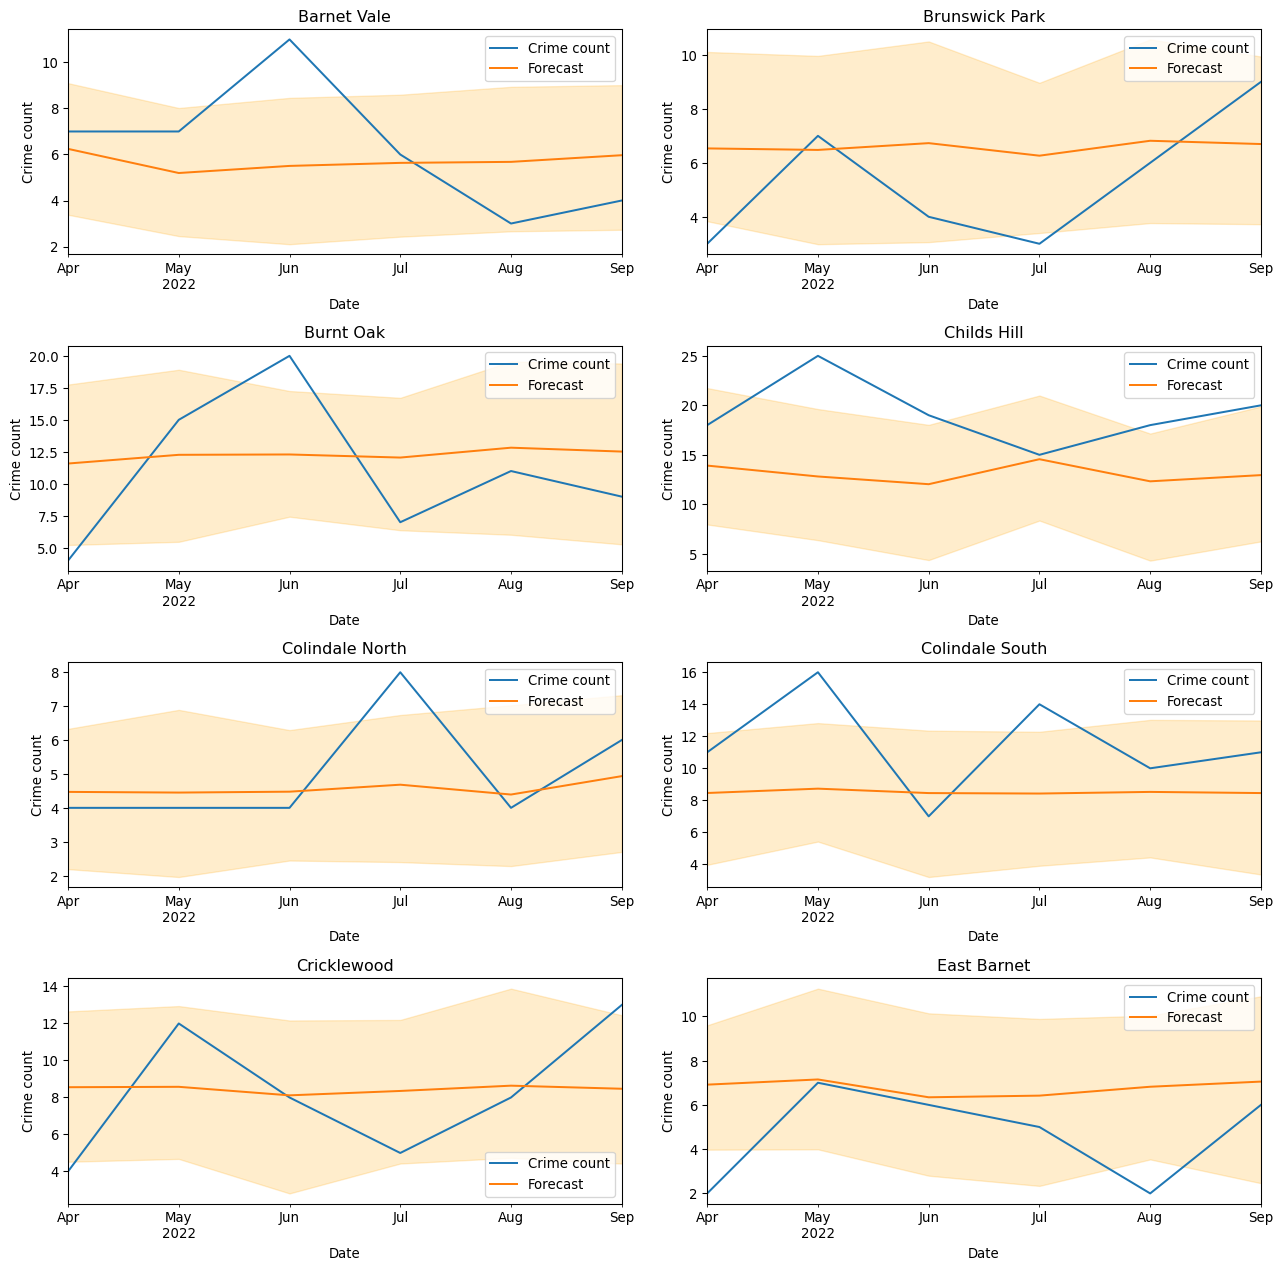

In [66]:
fig, ax = plt.subplots(4,2, figsize=(1280/96, 1280/96), dpi=96)
ax = ax.flatten()

for ax_ ,ward in enumerate(all_preds['Ward'].unique()[:8]):
    p_ = all_preds.loc[all_preds['Ward'] == ward]
    p_.plot(x='timestamp', y='crime_count', ax=ax[ax_], label='Crime count')
    p_.plot(x='timestamp', y='pred', ax=ax[ax_], label='Forecast')
    ax[ax_].fill_between(p_['timestamp'].values, p_['p10'], p_['p90'], alpha=0.2, color='orange')
    ax[ax_].set_title(ward)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Crime count')
fig.tight_layout()